## Importing Libraries

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import tensorflow as tf
import imageio
import numpy as np
import tensorboard
from huggingface_hub import push_to_hub_keras
from datetime import datetime

In [2]:
from tensorflow_docs.vis import embed

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
#necessary step to add for, if you want to train the model on GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

## Constants and Hyperparameters

In [5]:
batch_size = 128
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

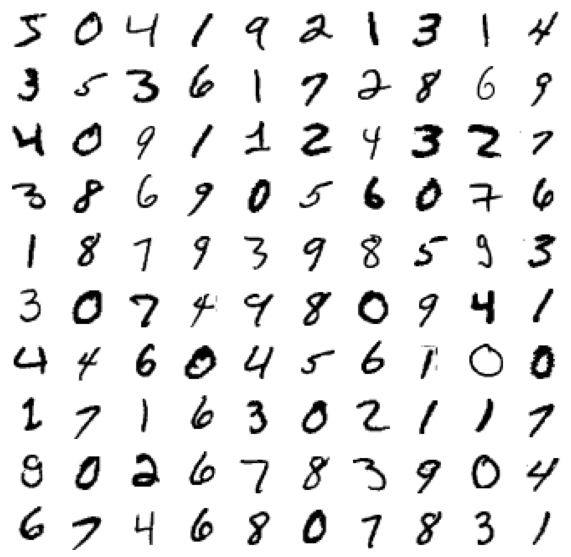

In [7]:
plt.figure(figsize=(10, 10))
for i in range(100):
    plt.subplot(10, 10, 1+i)
    plt.axis('off')
    plt.imshow(x_train[i], cmap='gray_r')
plt.show()

In [8]:
x_train.shape

(60000, 28, 28)

In [9]:
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

all_digits = all_digits.astype('float32') / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
all_labels = tf.keras.utils.to_categorical(all_labels, 10)

In [10]:
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size = 1024).batch(batch_size)

In [11]:
dataset

<BatchDataset shapes: ((None, 28, 28, 1), (None, 10)), types: (tf.float32, tf.float32)>

In [12]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_classes + num_channels

In [13]:
# Create the discriminator.
discriminator = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer((28, 28, discriminator_in_channels)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

# Create the generator.
generator = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer((generator_in_channels,)),
        # We want to generate 128 + num_classes coefficients to reshape into a
        # 7x7x(128 + num_classes) map.
        layers.Dense(7 * 7 * generator_in_channels),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, generator_in_channels)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)


In [14]:
class ConditionalGAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

In [15]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True),
)

In [16]:
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '500,520')

cond_gan.fit(dataset, epochs=100, callbacks = [tboard_callback])

Epoch 1/100
547/547 [==============================] - 29s 42ms/step - g_loss: 0.9079 - d_loss: 0.5562
Epoch 2/100
547/547 [==============================] - 22s 39ms/step - g_loss: 0.7848 - d_loss: 0.6480
Epoch 3/100
547/547 [==============================] - 21s 39ms/step - g_loss: 0.7817 - d_loss: 0.6501
Epoch 4/100
547/547 [==============================] - 21s 39ms/step - g_loss: 0.7802 - d_loss: 0.6509
Epoch 5/100
547/547 [==============================] - 22s 39ms/step - g_loss: 0.7754 - d_loss: 0.6566
Epoch 6/100
547/547 [==============================] - 22s 39ms/step - g_loss: 0.7714 - d_loss: 0.6570
Epoch 7/100
547/547 [==============================] - 22s 40ms/step - g_loss: 0.7632 - d_loss: 0.6641
Epoch 8/100
547/547 [==============================] - 22s 40ms/step - g_loss: 0.7611 - d_loss: 0.6669
Epoch 9/100
547/547 [==============================] - 22s 40ms/step - g_loss: 0.7558 - d_loss: 0.6678
Epoch 10/100
547/547 [==============================] - 22s 40ms/step - g

In [4]:
def save_plot(examples, n):
	plt.figure(figsize=(20, 20))
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	plt.show()

In [5]:
cgan_generator = tf.keras.models.load_model('cgan_generator.h5')

In [6]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	random_latent_vectors = tf.random.normal(shape=(n_samples, latent_dim))
	labels = tf.keras.utils.to_categorical(np.reshape([x for x in range(0, 10) for i in range(10)], (100)), 10)
	return tf.concat([random_latent_vectors, labels], 1)

In [9]:
random_vector_labels = generate_latent_points(128, 100)
X = cgan_generator.predict(random_vector_labels)

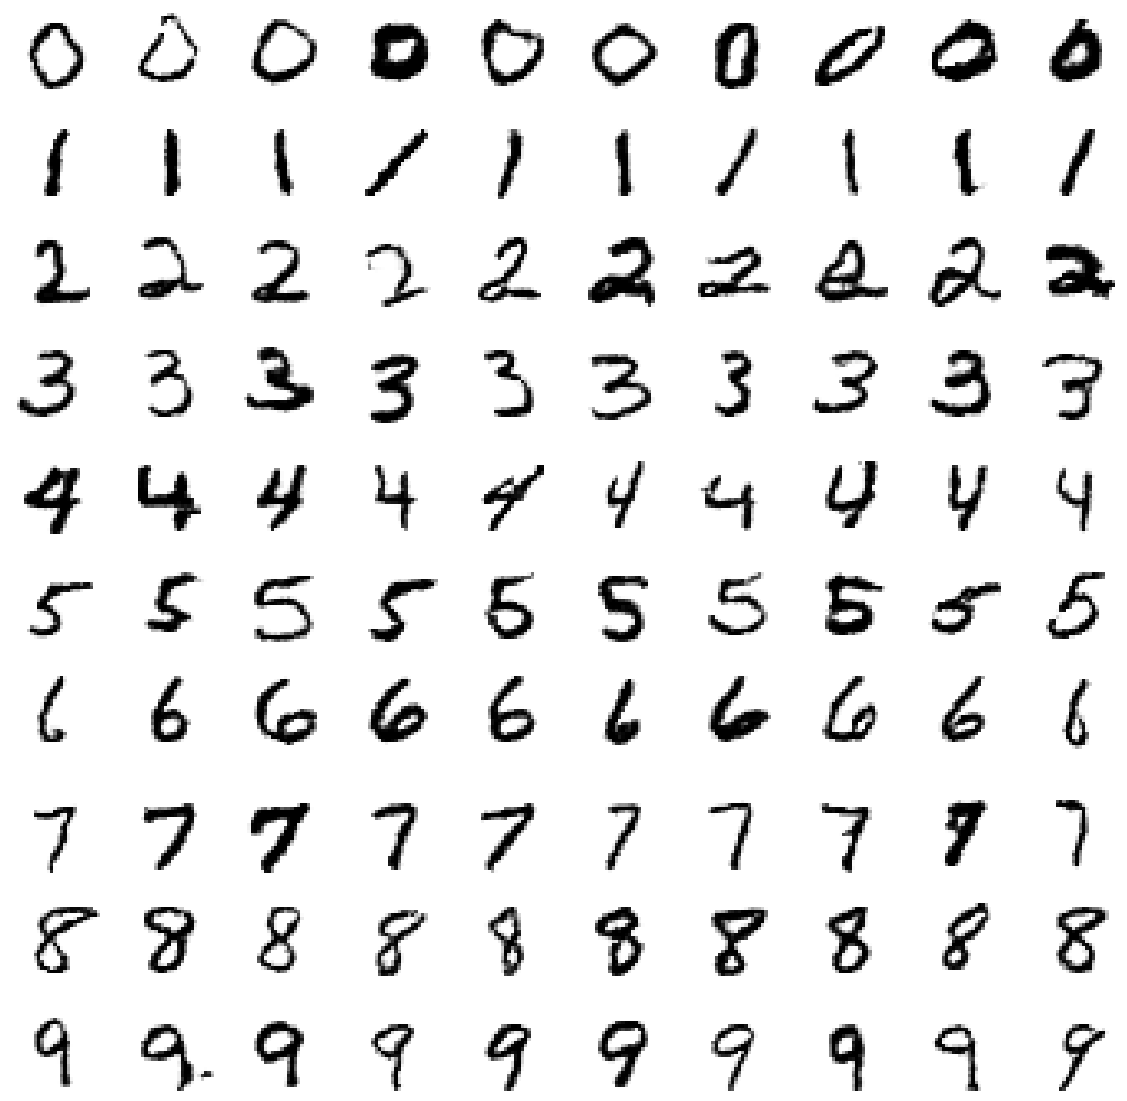

In [10]:
X = X * 255.0
converted_images = X.astype(np.uint8)
converted_images = tf.image.resize(converted_images, (96, 96)).numpy().astype(np.uint8)
# plot the result
save_plot(X, 10)

In [21]:
keras.models.save_model(cond_gan.generator, 'cgan_generator.h5')

In [ ]:
push_to_hub_keras